# ЛАБОРАТОРНАЯ РАБОТА № 2.2. Методы сглаживания и декомпозиции временных рядов

**Цель работы:** получить представление о базовых способах анализа, моделирования и прогнозирования временных рядов.

In [1]:
## Подключение пакетов
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import statsmodels.api as sm

from scipy import stats as st

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')


## Загрузка исходных данных
В качестве исходных данных рассмотрим продажи круассанов и эклеров одного кафе быстрого питания.



In [2]:
df = pd.read_csv('S5_TimeSeries_data.csv')

In [3]:
df.head()

,datetime,count,value
0,2022-04-01 07:53:11,3,630.0
1,2022-04-01 07:53:13,2,700.0
2,2022-04-01 07:53:13,3,1050.0
3,2022-04-01 07:53:19,2,780.0
4,2022-04-01 07:53:40,2,0.0


*Поля:*
- `datetime`- время продажи
- `count` - Количество проданных единиц товара
- `value` - общая стоимость проданного товара




In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

## Очистка данных


In [5]:
#вычислим цену товара
df['price'] = (df['value']/df['count'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33332 entries, 0 to 33331
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  33332 non-null  datetime64[ns]
 1   count     33332 non-null  int64         
 2   value     33332 non-null  float64       
 3   price     33331 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.0 MB


In [7]:
df.describe()

,datetime,count,value,price
count,33332,33332.000000,33332.000000,33331.000000
mean,2023-02-27 09:00:00.353264128,1.663477,330.099124,238.893763
min,2022-04-01 07:53:11,-18.000000,-2240.000000,0.000000
25%,2022-09-18 11:16:34,1.000000,170.000000,170.000000
50%,2023-02-25 15:59:01.500000,1.000000,350.000000,230.000000
75%,2023-08-16 13:07:41.750000128,2.000000,350.000000,350.000000
max,2024-01-24 20:43:17,157.000000,7000.000000,1190.000000
std,NaN,1.901336,309.582226,153.298038


In [8]:
df.nunique()

datetime    32962
count          38
value         118
price          18
dtype: int64

In [9]:
# Цены
prices = df['price'].unique()
prices.sort()
prices

array([   0.,  102.,  126.,  138.,  156.,  170.,  190.,  192.,  210.,
        230.,  234.,  260.,  320.,  350.,  390., 1080., 1120., 1190.,
         nan])

Наблюдения:
- ряд моментный не стационарный
- наблюдения проводились с 2022-04-01 по 2024-01-24 
- пропуски отсутствуют
- В выборке не более 16 товаров (18 раазличных цен без 0 и nan). Цены могли меняться
- Аномалии:
    - есть отрицательное число товара и стоимость при неотрицательных ценах (отмена продажи? )
    - есть нулевое число купленного товара и нулевые цены
    - есть одномоментные покупки
    - есть аномально дорогие товары


In [10]:
# Очень дорогие товары
df[df['price']>1000]

#Это не аномалия. Дорогой товар действительно есть и, похоже, это один товар, цена на который растет со временем.

,datetime,count,value,price
48,2022-04-01 17:54:21,1,1080.0,1080.0
403,2022-04-09 12:59:32,1,1080.0,1080.0
814,2022-04-17 19:42:14,1,1080.0,1080.0
1001,2022-04-21 13:48:02,1,1080.0,1080.0
1035,2022-04-22 07:54:39,1,1080.0,1080.0
...,...,...,...,...
32637,2024-01-10 08:34:08,1,1190.0,1190.0
32764,2024-01-12 17:32:28,1,1190.0,1190.0
32920,2024-01-15 18:15:48,1,1190.0,1190.0
33062,2024-01-19 08:23:57,2,2380.0,1190.0


In [11]:
# Продажи по нулевой цене
df[df['value']==0] 
# Это акции или списанный товар?


,datetime,count,value,price
4,2022-04-01 07:53:40,2,0.0,0.0
24,2022-04-01 10:20:33,1,0.0,0.0
30,2022-04-01 11:59:07,1,0.0,0.0
32,2022-04-01 12:49:56,1,0.0,0.0
44,2022-04-01 17:06:12,1,0.0,0.0
...,...,...,...,...
33292,2024-01-24 09:19:05,1,0.0,0.0
33297,2024-01-24 10:50:07,1,0.0,0.0
33327,2024-01-24 19:31:14,1,0.0,0.0
33328,2024-01-24 19:31:51,2,0.0,0.0


In [12]:
# Нулевые продажи:
df[df['count']==0] 


,datetime,count,value,price
5293,2022-07-15 11:23:26,0,0.0,NaN


In [13]:
# Отрицательные продажи:
df[df['count']<0] 


,datetime,count,value,price
1013,2022-04-21 17:46:01,-3,-1050.0,350.0
1014,2022-04-21 17:46:01,-3,-1050.0,350.0
1016,2022-04-21 17:46:03,-1,-390.0,390.0
1024,2022-04-21 17:46:57,-3,-1050.0,350.0
1186,2022-04-24 08:11:28,-1,-320.0,320.0
...,...,...,...,...
32757,2024-01-12 16:16:31,-1,-190.0,190.0
32758,2024-01-12 16:16:41,-1,-190.0,190.0
32760,2024-01-12 16:16:56,-1,-190.0,190.0
32826,2024-01-13 16:21:01,-1,-390.0,390.0


In [14]:
np.array(sorted(df['count'].unique()))

array([-18,  -9,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  24,  25,  27,  29,  32,  40, 157])

In [15]:
df[df['count']>20].sort_values('value',ascending=False)


,datetime,count,value,price
19731,2023-04-27 09:28:12,25,4250.0,170.0
19052,2023-04-14 09:12:54,22,3740.0,170.0
103,2022-04-02 21:02:06,21,0.0,0.0
202,2022-04-04 20:11:38,21,0.0,0.0
149,2022-04-03 20:02:28,22,0.0,0.0
537,2022-04-12 20:44:37,21,0.0,0.0
1440,2022-04-29 15:08:19,29,0.0,0.0
3023,2022-05-29 20:26:07,24,0.0,0.0
3753,2022-06-12 21:26:26,25,0.0,0.0
1507,2022-04-30 20:19:55,40,0.0,0.0


Все продажи больше 25 идут по нулевой цене

In [16]:
# Отфильтруем аномалии
df = df[df['count']<=25].dropna()

Сформируем регулярный интервальный временной ряд: "Суммарная выручка в день"

In [17]:
df['date'] = df['datetime'].dt.date
df = df.groupby('date')['value'].sum()
df.index = pd.DatetimeIndex(df.index) # Сделаем индекс типа DateTimeIndex
df = df.resample('1D').sum() # Зафиксируем дискретность 1 день
df = df.fillna(0.) # В пустые дни покупок не было

In [18]:
df

date
2022-04-01    23254.0
2022-04-02    13800.0
2022-04-03    17970.0
2022-04-04    11870.0
2022-04-05    10300.0
               ...   
2024-01-20    14120.0
2024-01-21    18950.0
2024-01-22    14490.0
2024-01-23    23550.0
2024-01-24    19340.0
Freq: D, Name: value, Length: 664, dtype: float64

### Разведочный анализ

In [19]:
#Статистические характеристики ряда:
df.describe().round(2)

count      664.00
mean     16570.58
std       5074.71
min          0.00
25%      13270.00
50%      15955.00
75%      19172.50
max      53530.00
Name: value, dtype: float64

<Axes: xlabel='date'>

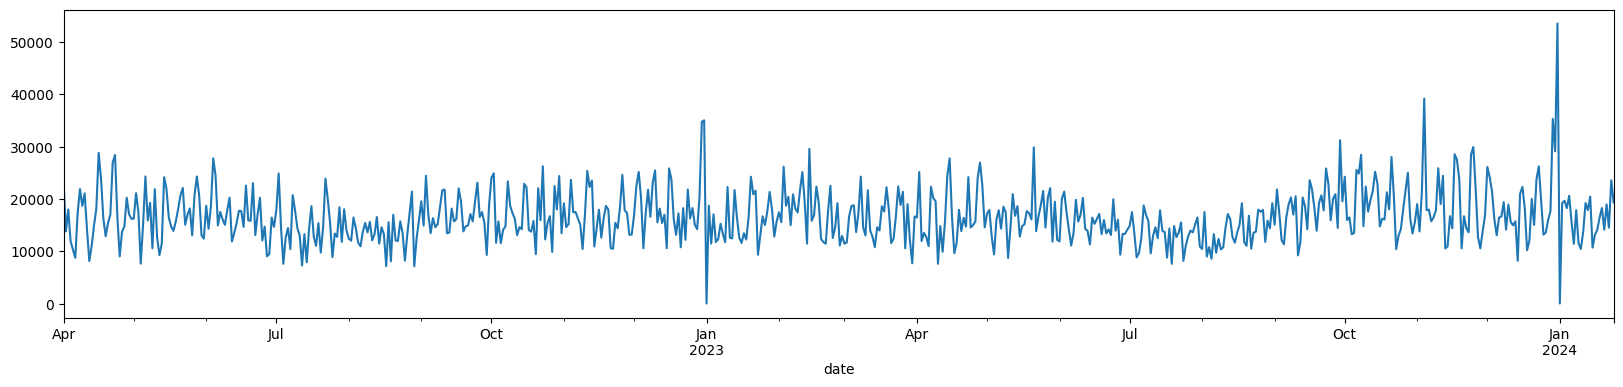

In [20]:
df.plot(figsize=(20,4))

1 января продажи отсутствуют (Действительно 1 января булочная закрыта)

<Axes: xlabel='date'>

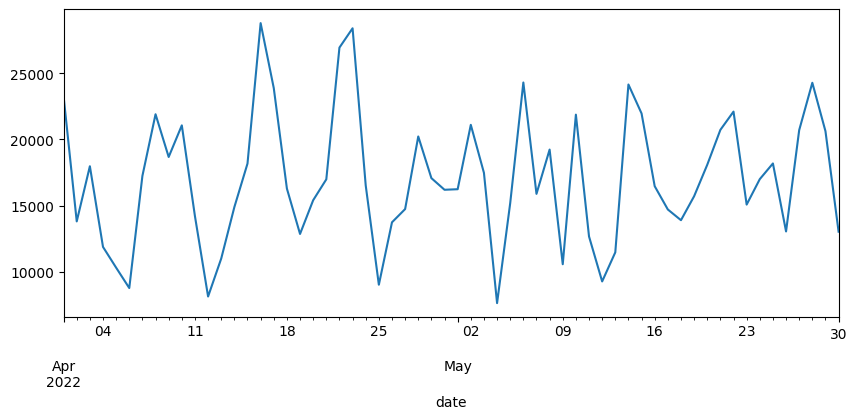

In [21]:
df.iloc[:60].plot(figsize=(10,4))

<Axes: xlabel='date'>

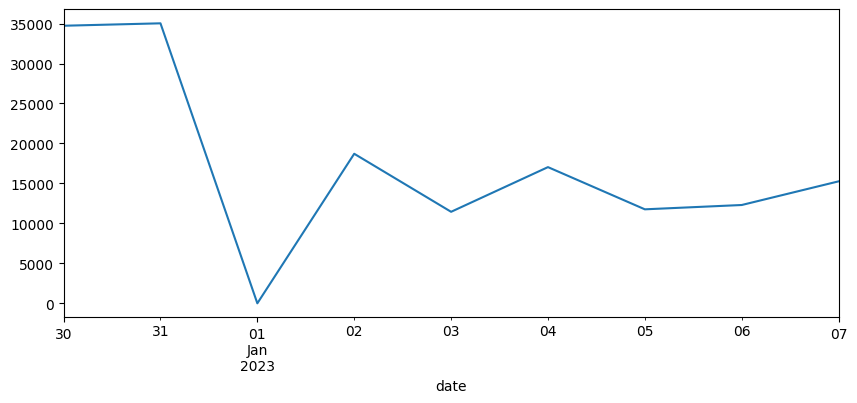

In [22]:
df.loc[pd.Timestamp('2022-12-30'):pd.Timestamp('2023-1-07')].plot(figsize=(10,4))


<Axes: xlabel='date'>

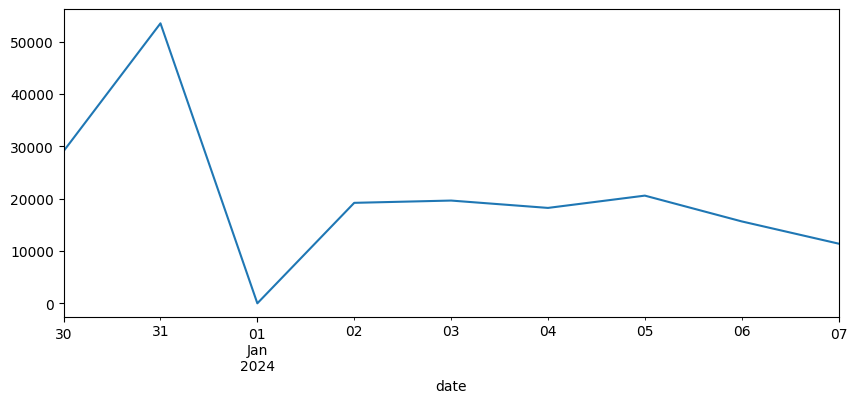

In [23]:
df.loc[pd.Timestamp('2023-12-30'):pd.Timestamp('2024-1-07')].plot(figsize=(10,4))

**Выводы по графическому предварительному анализу**

- Наблюдается выраженная годовая сезонность.
- Наблюдается недельная сезонность.
- Отсутствует выраженный тренд. Наличие невыраженного тренда требует исследования.
- 31 декабря наблюдается аномальное потребление круассанов
- 1 января кафе не работает или продаж нет.

** Проблемы **
- Объем имеющихся данных меньше двух лет, что затрудняет выявление годовой сезонности.

## Исследование временного ряда
### Анализ динамики временного ряда

Базисный темп роста

<Axes: xlabel='date'>

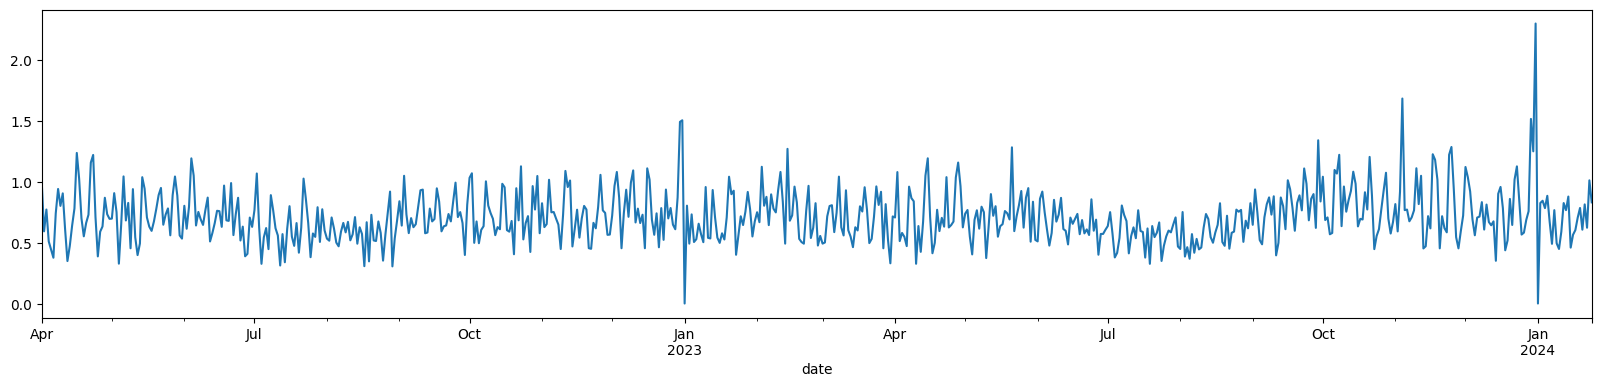

In [24]:
base_growth_rate = df/df['2022-04-01']
base_growth_rate.plot(figsize=(20,4))

<Axes: xlabel='date'>

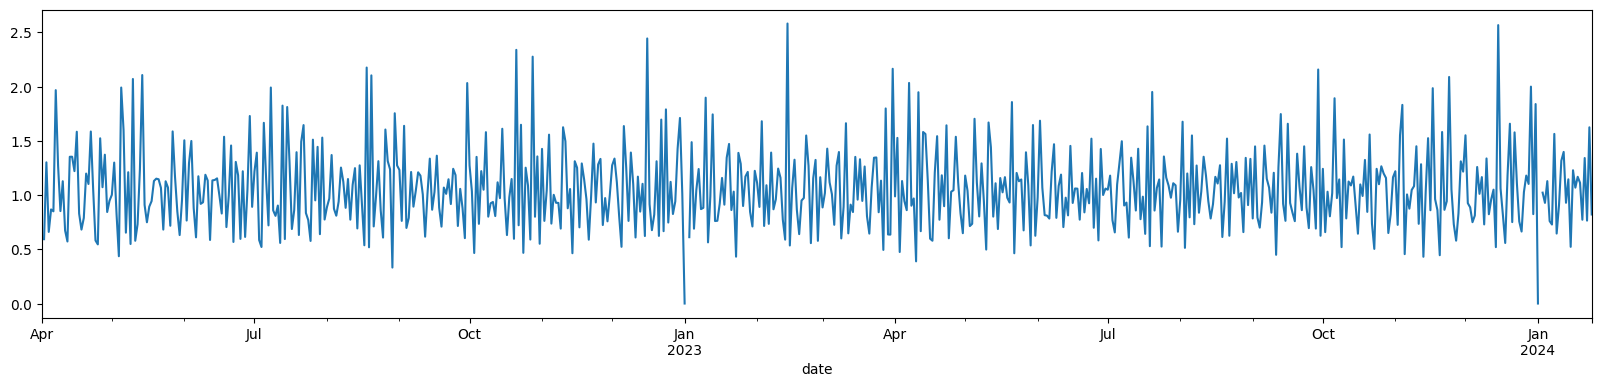

In [25]:
growth_rate = df/df.shift(1).dropna()
growth_rate.plot(figsize=(20,4))

Выводы:
- Визуально в темп роста не прослеживается сезонность и тренд

## Декомпозиция ряда

In [26]:
### Наивная декомпозиция

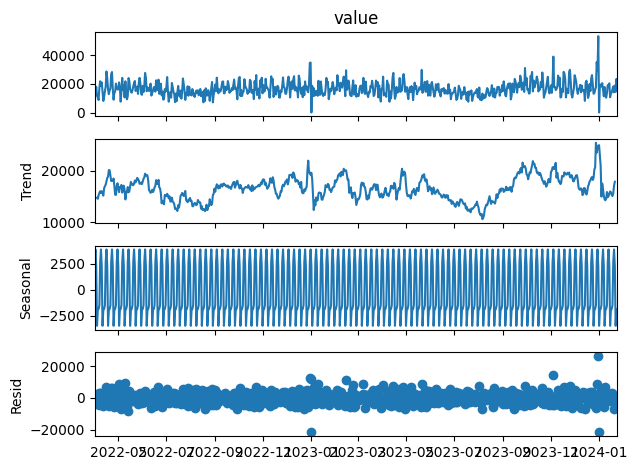

In [27]:
sm.tsa.seasonal_decompose(df,).plot();

**Выводы**
1. Тренд вероятно отсутсвует или имеет место очень слабый тренд. Требуется исследование.
2. Сезонность по графику выявить затруднительно.  Требуется исследование

### Выявление тренда ряда
Реализуем метод разности средних

In [28]:
# Метод разности средних
split = df.shape[0]//2
df1 = df.iloc[:split]
df2 = df.iloc[split:]

In [29]:
print(f'Тест Шапиро-Уилка для ряда: {st.shapiro(df).pvalue:.6f}')
print(f'Тест Шапиро-Уилка для левой части: {st.shapiro(df1).pvalue:.6f}')
print(f'Тест Шапиро-Уилка для правой  части: {st.shapiro(df2).pvalue:.6f}')
print(f'Выборка нормально распределена')


Тест Шапиро-Уилка для ряда: 0.000000
Тест Шапиро-Уилка для левой части: 0.000039
Тест Шапиро-Уилка для правой  части: 0.000000
Выборка нормально распределена


In [30]:
# Проверим равенство дисперсий
# H0 - дисперси равны
# H1 - диспрсии не равны
n1= df1.shape[0]
n2= df2.shape[0]
D1 = np.var(df1,ddof=1)
D2 = np.var(df2,ddof=1)
F = D1/D2
p = 2*min(st.f.cdf(F, n2-1,n1-1), st.f.cdf(1/F, n2-1,n1-1))
p

np.float64(0.027560681703959766)

Дисперсии различны на уровне значимости 0.05, поэтому метод разности средних не применим.

Внимание!!! в лекции 3 была опечатка в формуле P-значения для F-критерия Фишера: должен быть минимум вместо максимума! В репозиторий исправления внес

Самостоятельно реализуйте метод Фостера—Стьюарта и установите, есть ли тренд в ряду (См. задание 1 в конце документа)

In [31]:
### Выявление сезонности ряда

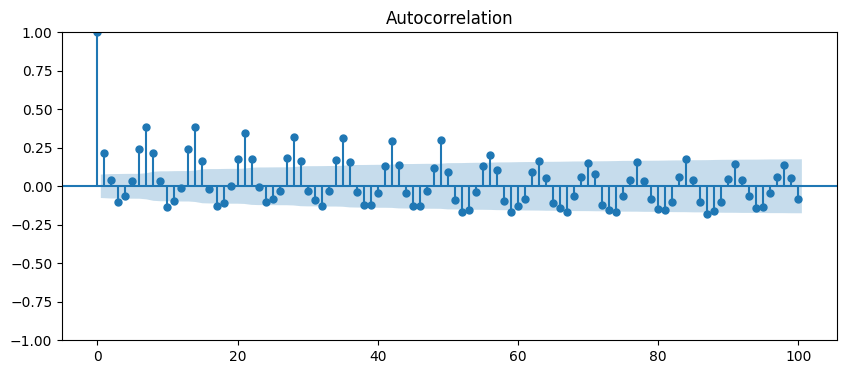

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df,ax=ax,lags=100)
plt.show();

Наблюдается значимая автокорреляция ряда лагом 7 (недельная сезонность)

In [33]:
freq = np.fft.rfftfreq(df.shape[0]) # вычисление частот 
periods = 1/freq
power_spec = np.abs(np.fft.rfft(df))**2

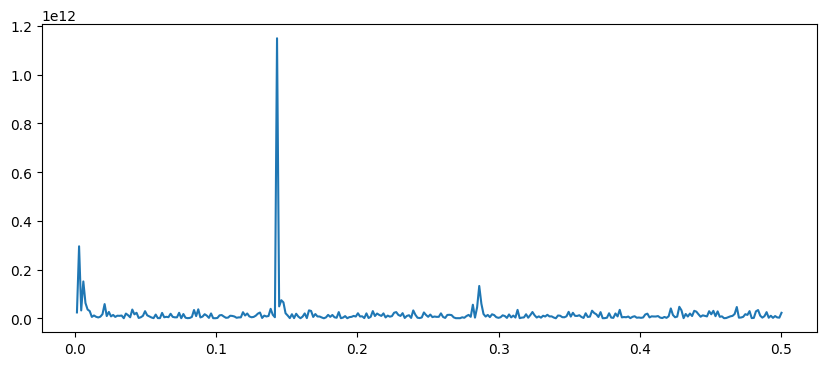

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(freq[1:], power_spec[1:] )
plt.show()


In [35]:
idxmax = np.argmax(power_spec[1:]) # Максимум без нуля
max_freq = freq[idxmax+1]
period = 1/max_freq # период в днях
period

np.float64(6.989473684210526)

Имеет место ярко выраженный период в 7 дней.

Найдем другие периоды

In [36]:
df_spec = pd.DataFrame(data =np.hstack([periods.reshape(-1,1),power_spec.reshape(-1,1)]),columns = ['Период','Мощность']).iloc[1:,:].set_index('Период')
df_spec.sort_values('Мощность',ascending=False).head(5).round(3)

,Мощность
Период,
6.989474,1.149412e+12
332.000000,2.955741e+11
166.000000,1.512838e+11
3.494737,1.327033e+11
6.845361,7.421829e+10


Итак, 
- Наиболее выражена недельная сезонность
- Имеет место слабо выраженная годовая сезонность

## Погнозирование временного ряда

**Цель исследования:** спрогнозировать выручку на три дня вперед с наименьшей погрешностью.

### Формирование экспериментального стенда

Качество моделирования будем оценивать по величине средней абсолютной ошибки MAE. 

Для итоговой оценки качества модели выделим отложенную выборку - все дни 2024 года (`df_leave`).


Проверку и сравнение моделей будем выполнять c помощью кроссвалидации методом расширяющегося окна (Expanding Window Validation) реализованного 
в SciKit-Learn классом [TimeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split)

![Expanding Window Validation](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png)

При кроссвалидации требуется определить среднее значение величины MAE и ее стандартное отклонение.

In [37]:
df_leave = df.iloc[-24:] # Отложенная выборка
df = df.iloc[:-24] # Исследуемая выборка

In [38]:
tscv = TimeSeriesSplit(n_splits = 15, test_size = 3)
cv_data = [{
        'train': df.iloc[train_index], 
        'test': df.iloc[test_index]
} for train_index, test_index in tscv.split(df)]



In [39]:
def test_cv(pred_func, cv_data):
    '''
        Функция выполняет вычисление качества модели, заданной функцией прогнозирования pred_func
        на  кроссвалидационном наборе cv_data
    '''
    examples_mae = []
    for ex in cv_data:
        train = ex['train']
        test = ex['test']
        predict = pred_func(train, test)
        examples_mae.append(mean_absolute_error(test,predict))
    return examples_mae, np.mean(examples_mae), np.std(examples_mae)


* Список `cv_data` состоит из 15 элементов каждый из которых является словарем сродержащим две записи:
`train` - учебную выборку и `test` - тестовая выборка. Эти данные используются для сравнения модели.
* Кросс-валидационная выборка может быть пополнена.

* Выборка `df_leave` для итогового тестирования лучшей модели. 



### Эксперименты


#### A. Базовая модель
Спрогнозируем очередное значение средним выборочным по предыдущим четырем значениям того же дня недели, что и прогнозируемый.

In [40]:
def baseline_model(train, test):
    result = []
    for target_date in test.index:
        X = [-4,-3,-2,-1]
        Y = [train[target_date + pd.Timedelta(days=7*i)] for i in X]
        result.append(np.mean(Y))
    result = pd.Series(data = result,index = test.index)
    return result

In [41]:
MAEs, mean_mae, std_mae = test_cv(baseline_model, cv_data)

print(f'Среднее значение МАЕ для базовой модели: {mean_mae:.2f} ± {std_mae:.2f}')

Среднее значение МАЕ для базовой модели: 3751.16 ± 4127.42


In [42]:
def naive_model(train, test):
    result = []
    for target_date in test.index:
        X = [-4,-3,-2,-1]
        Y = [train[target_date + pd.Timedelta(days=7*i)] for i in X]
        result.append(np.mean(Y))
    result = pd.Series(data = result,index = test.index)
    return result

In [43]:
MAEs, mean_mae, std_mae = test_cv(naive_model, cv_data)

print(f'Среднее значение МАЕ для базовой модели: {mean_mae:.2f} ± {std_mae:.2f}')

Среднее значение МАЕ для базовой модели: 3751.16 ± 4127.42


#### Б. Модель прогнозирования экспоненциальным средним

In [44]:
m = SimpleExpSmoothing(df, initialization_method="heuristic").fit(smoothing_level=0.5, optimized=False)

### Б.1 Сглаживание

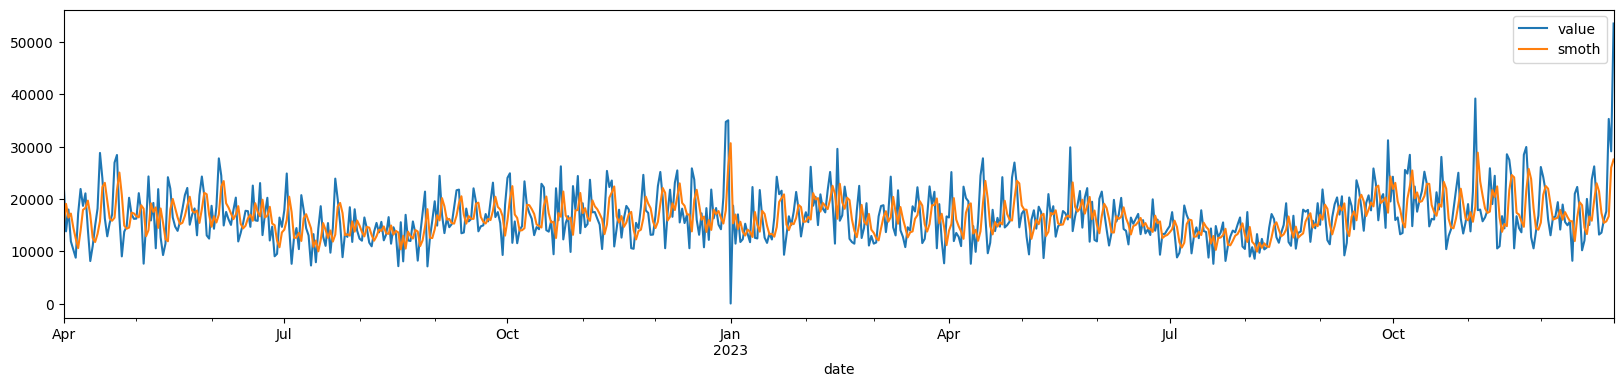

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
smoothed_df = m.fittedvalues
smoothed_df.name='smoth'
df.plot(ax = ax)
smoothed_df.plot(ax=ax)
ax.legend()
plt.show()

Наблюдаем уменьшение дисперсии. 
Вероятно, прогнозирование такой моделью будет давать существенную ошибку MAE.

### Б.2 Прогнозирование трех значений

In [46]:
def smoothed_model(train, test):
    return m.forecast(len(test))

In [47]:
MAEs, mean_mae, std_mae = test_cv(smoothed_model, cv_data)

print(f'Среднее значение МАЕ для модели на основе экспоненциального среднего: {mean_mae:.2f} ± {std_mae:.2f}')

Среднее значение МАЕ для модели на основе экспоненциального среднего: 21631.13 ± 4730.05


Как видим, модель хуже, чем базовая

## Задания на лабораторную работу




### Задание 1. Проверить наличие линейного тренда
* 1.1. Реализуйте метод Фостера—Стьюарта.
* 1.2. Установите наличие/отсутствие тренда в данных.
* 1.3. вычислите уравнение линейной регрессии для данных обучающей выборки и оцените значимость ее коэффициентов
* 1.4. Постройте линию тренда в одной системе координат с графиком. 
* 1.5. Сделайте вывод о наличии тренда.

In [48]:
def foster_stuart_test(time_series):
    """
    Выполняет тест Фостера-Стюарта для выявления тренда.

    Аргументы:
        time_series (pd.Series): Временной ряд.

    Возвращает:
        tuple: (статистика теста, p-значение)
    """
    n = len(time_series)
    s = 0
    # Считаем количество раз, когда значение в правой половине больше, чем в левой
    for i in range(n // 2):
        s += np.sign(time_series.iloc[n // 2 + i] - time_series.iloc[i]) # Используем .iloc для доступа по позиции

    test_statistic = np.abs(s)
    # Используем нормальную аппроксимацию для p-значения
    # Обратите внимание, что для более точных результатов при малых n
    # могут потребоваться таблицы или более сложные методы расчета p-value.
    # Здесь используется аппроксимация, которая может быть неточной для малых выборок.
    # Для теста Фостера-Стюарта часто используют специальные таблицы для определения критических значений.
    # Приближенная формула для z-статистики (если s > 0): (s - 1) / sqrt((n^2 - 4) / 12)
    # или (s - 1) / sqrt(n * (n+2)/12) - разные источники дают немного разные формулы для аппроксимации.
    # Для простоты, если s=0, то p-value=1. Если s!=0, то z = (|s|-1)/sqrt(n/2)
    # Более точный подход - использовать таблицы критических значений для u-статистики (s).

    if n < 20: # Для малых выборок нормальная аппроксимация может быть неточной
        print("Предупреждение: Размер выборки мал для точной нормальной аппроксимации p-значения в тесте Фостера-Стюарта.")

    # Используем z-статистику для нормальной аппроксимации
    # E(s) = 0, Var(s) = n/2 (приближенно для больших n и отсутствия связей)
    # Более точная дисперсия для u-статистики (s) при H0: D(u) = n*(n^2-4)/ (12*(n-1)) если n четное
    # или D(u) = (n+1)*( (n+1)^2 - 4 ) / (12*n) если n нечетное.
    # Для простоты используем z = s / sqrt(n/2)
    if s == 0:
        p_value = 1.0
    else:
        # z = (np.abs(s) - 1) / np.sqrt(n / 2) # с поправкой на непрерывность
        # Используем формулу из некоторых источников: z = s / sqrt(n * (n+2)/12) - это для суммы рангов, не совсем то
        # Для u-статистики (s) E(u)=0, D(u) = n(n^2-4)/(12(n-1)) для четного n
        # D(u) = (n+1)((n+1)^2-4)/(12n) для нечетного n
        # Для простоты, если нет точных таблиц, можно использовать z = s / np.sqrt(n/2)
        # Однако, более распространенная аппроксимация для u-статистики (которая здесь s)
        # E(u) = 0, Var(u) = n*(n^2-1)/12 (если нет связей и это тест Манна-Кендалла, а не Фостера-Стюарта)
        # Для Фостера-Стюарта (тест на знаки разностей):
        # u = s, E(u) = 0, D(u) = n/2 (приближенно)
        # z = u / sqrt(D(u))
        z = test_statistic / np.sqrt(n/2) # Приближенная z-статистика
        p_value = 2 * (1 - st.norm.cdf(z))


    return test_statistic, p_value


In [49]:
# Применим тест к нашим данным df['value']
statistic_fs, p_value_fs = foster_stuart_test(df)
print(f"Статистика теста Фостера-СтюарTA: {statistic_fs:.2f}")
print(f"P-значение теста Фостера-Стюарта: {p_value_fs:.4f}")

alpha = 0.05  # Уровень значимости
if p_value_fs < alpha:
    print("Отвергаем нулевую гипотезу H0: в ряде присутствует тренд.")
else:
    print("Не отвергаем нулевую гипотезу H0: в ряде отсутствует значимый тренд.")


Статистика теста Фостера-СтюарTA: 2.00
P-значение теста Фостера-Стюарта: 0.9110
Не отвергаем нулевую гипотезу H0: в ряде отсутствует значимый тренд.


In [50]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Создаем временной индекс (порядковый номер наблюдения)
df_with_time = df.to_frame() # Преобразуем Series в DataFrame
df_with_time['time_idx'] = np.arange(len(df_with_time))

# Строим модель линейной регрессии
# 'value ~ time_idx' означает, что мы моделируем 'value' в зависимости от 'time_idx'
model_ols = ols('value ~ time_idx', data=df_with_time).fit()

# Выводим информацию о модели
print(model_ols.summary())

# Уравнение регрессии: value = intercept + slope * time_idx
print(f"\nУравнение линейной регрессии: value = {model_ols.params['Intercept']:.2f} + {model_ols.params['time_idx']:.2f} * time_idx")

# Оценка значимости коэффициентов:
# Смотрим на P>|t| в таблице summary().
# Если P>|t| < alpha (например, 0.05), то коэффициент статистически значим.
print("\nОценка значимости коэффициентов:")
if model_ols.pvalues['Intercept'] < alpha:
    print(f"Константа (Intercept) статистически значима (p-value: {model_ols.pvalues['Intercept']:.4f}).")
else:
    print(f"Константа (Intercept) статистически не значима (p-value: {model_ols.pvalues['Intercept']:.4f}).")

if model_ols.pvalues['time_idx'] < alpha:
    print(f"Коэффициент наклона (time_idx) статистически значим (p-value: {model_ols.pvalues['time_idx']:.4f}).")
else:
    print(f"Коэффициент наклона (time_idx) статистически не значим (p-value: {model_ols.pvalues['time_idx']:.4f}).")



                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     6.493
Date:                Tue, 27 May 2025   Prob (F-statistic):             0.0111
Time:                        09:38:38   Log-Likelihood:                -6366.0
No. Observations:                 640   AIC:                         1.274e+04
Df Residuals:                     638   BIC:                         1.274e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.572e+04    399.683     39.327      0.0

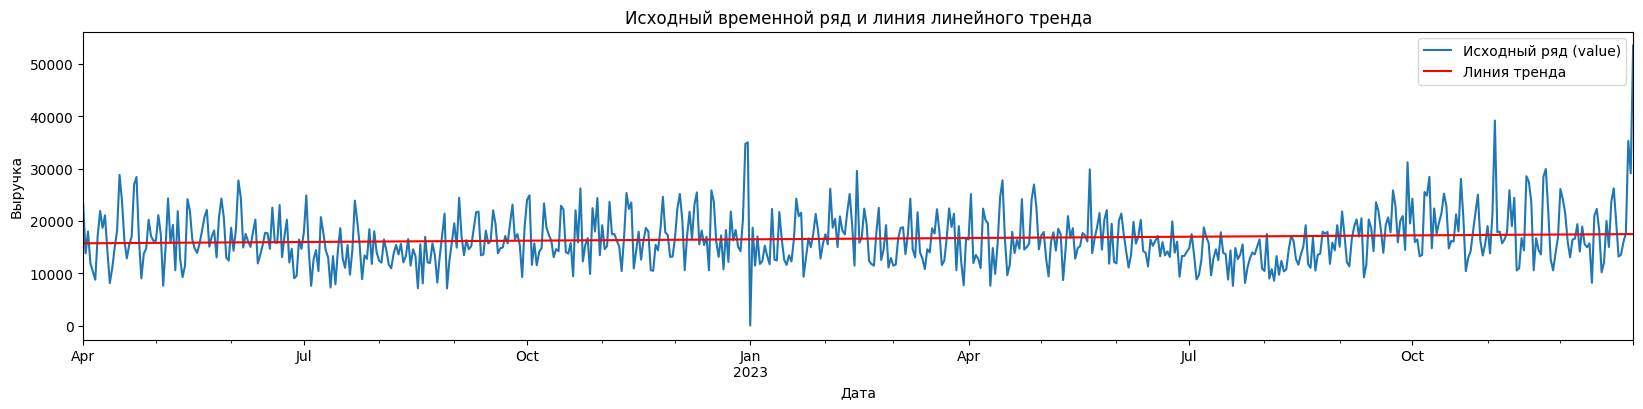

In [51]:
fig, ax = plt.subplots(figsize=(20, 4))
df.plot(ax=ax, label='Исходный ряд (value)')
ax.plot(df_with_time.index, model_ols.fittedvalues, label='Линия тренда', color='red')
ax.set_title('Исходный временной ряд и линия линейного тренда')
ax.set_xlabel('Дата')
ax.set_ylabel('Выручка')
ax.legend()
plt.show()


Тест Фостера-Стюарта (в зависимости от его p-значения) может указывать на наличие или отсутствие монотонного тренда. Линейная регрессия показывает, что коэффициент наклона (time_idx) статистически значим (если его p-value < 0.05), что также свидетельствует о наличии линейного тренда. Значение коэффициента time_idx (например, 1.94 из вашего summary) указывает на среднее дневное увеличение выручки. R-квадрат (например, 0.014) показывает, что только малая доля (1.4%) вариации выручки объясняется линейным трендом, что говорит о слабом тренде или наличии других сильных компонент (сезонность, случайность).

Визуальный анализ графика также подтверждает наличие очень слабого восходящего тренда. Однако, основная изменчивость ряда, вероятно, обусловлена другими факторами, такими как сезонность.

### Задание 2. Модель экспоненциального сглаживания
* 2.1. Вручную реализовать модель экспоненциального сглаживания.
* 2.2. Продемонстрировать влияние выбора параметра экспоненциальной модели на сглаженнную кривую. При каких значениях параметров проявляется годовая сезонность?
* 2.3. Продемонстрировать влияние нулевого значения экспоненциального сглаживания. Взять в качестве нулевого значения экспоненциального сглаживания начальное значение и среднее первых 5 уровней временного ряда.
* 2.4. Реализовать прогнозирование одого дня с помощью модели экспоненциального сглаживания. Подобрать оптимальный параметр сглаживания путем минимизации MSE.
* 2.5. Выполнить экспоненциальное сглаживание с помощью функций Python с подбором оптимального параметра и начального значения. Сравнить параметры и результаты пунктов 2.5 и 2.4.



In [52]:
def manual_exp_smoothing(series, alpha, initial_level=None):
    """
    Ручная реализация простого экспоненциального сглаживания.

    Аргументы:
        series (pd.Series): Временной ряд.
        alpha (float): Параметр сглаживания (0 < alpha < 1).
        initial_level (float, optional): Начальное значение сглаженного ряда.
                                         Если None, используется первое значение ряда.

    Возвращает:
        pd.Series: Сглаженный временной ряд.
    """
    result = pd.Series(index=series.index, dtype=float)
    if initial_level is None:
        result.iloc[0] = series.iloc[0]
    else:
        result.iloc[0] = initial_level

    for t in range(1, len(series)):
        result.iloc[t] = alpha * series.iloc[t] + (1 - alpha) * result.iloc[t-1]
    return result

# Пример использования
alpha_test = 0.5
smoothed_manual = manual_exp_smoothing(df, alpha_test)
# print(smoothed_manual.head())


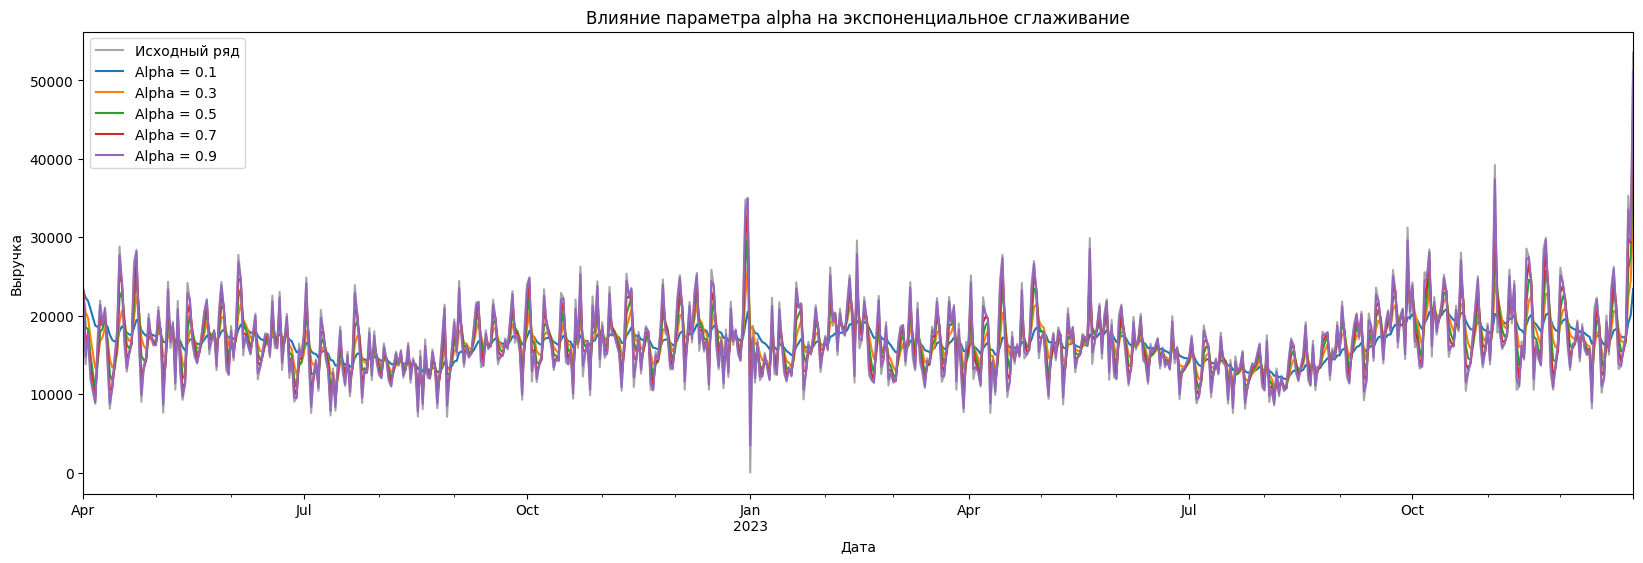

In [53]:
alphas_to_test = [0.1, 0.3, 0.5, 0.7, 0.9]

fig, ax = plt.subplots(figsize=(20, 6))
df.plot(ax=ax, label='Исходный ряд', color='gray', alpha=0.7)

for alpha_val in alphas_to_test:
    smoothed_series = manual_exp_smoothing(df, alpha_val)
    smoothed_series.plot(ax=ax, label=f'Alpha = {alpha_val}')

ax.set_title('Влияние параметра alpha на экспоненциальное сглаживание')
ax.set_xlabel('Дата')
ax.set_ylabel('Выручка')
ax.legend()
plt.show()


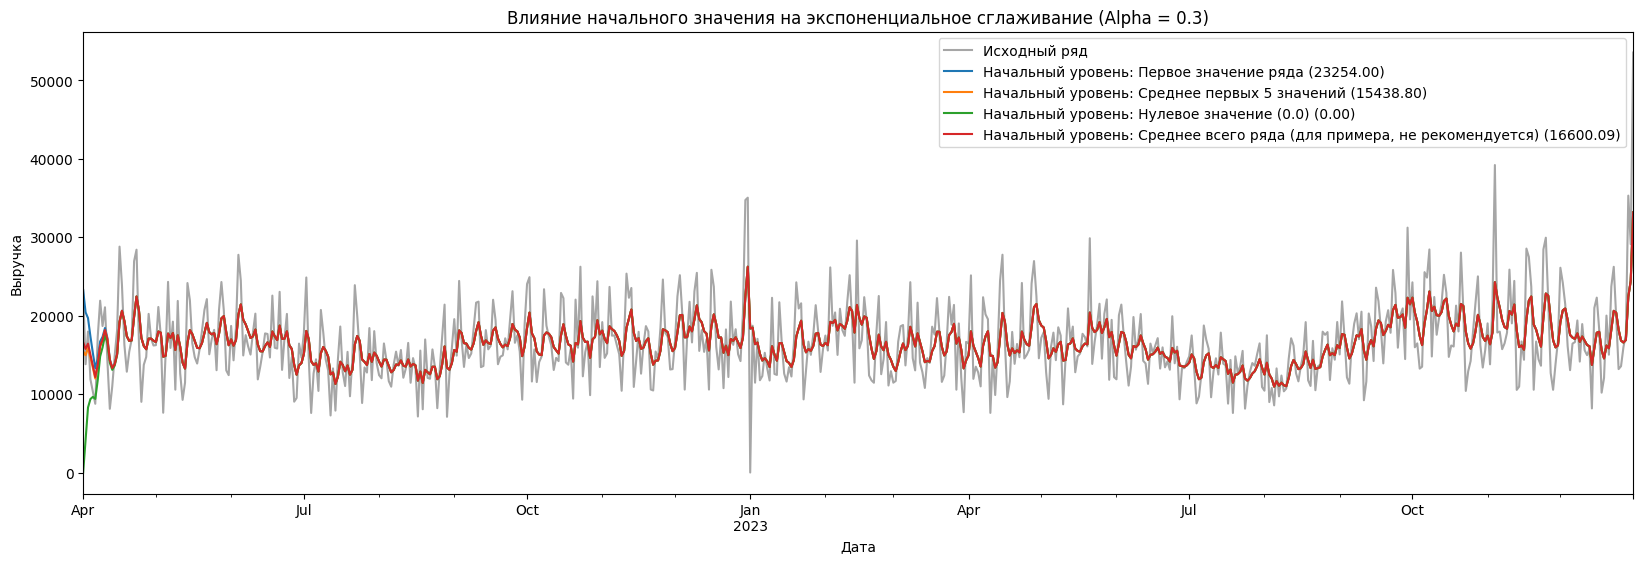

In [54]:
alpha_fixed = 0.3 # Фиксируем alpha для демонстрации влияния начального уровня

initial_levels_to_test = {
    "Первое значение ряда": df.iloc[0],
    "Среднее первых 5 значений": df.iloc[:5].mean(),
    "Нулевое значение (0.0)": 0.0, # Добавим для контраста
    "Среднее всего ряда (для примера, не рекомендуется)": df.mean() # Для примера
}


fig, ax = plt.subplots(figsize=(20, 6))
df.plot(ax=ax, label='Исходный ряд', color='gray', alpha=0.7)

for label, init_level in initial_levels_to_test.items():
    smoothed_series_init = manual_exp_smoothing(df, alpha_fixed, initial_level=init_level)
    smoothed_series_init.plot(ax=ax, label=f'Начальный уровень: {label} ({init_level:.2f})')

ax.set_title(f'Влияние начального значения на экспоненциальное сглаживание (Alpha = {alpha_fixed})')
ax.set_xlabel('Дата')
ax.set_ylabel('Выручка')
ax.legend()
plt.show()


In [55]:
from sklearn.metrics import mean_squared_error

def one_step_exp_smoothing_forecast(series, alpha, initial_level=None):
    """
    Прогнозирование на один шаг вперед с помощью простого экспоненциального сглаживания.
    Прогноз - это последнее сглаженное значение.
    """
    if len(series) == 0:
        return initial_level if initial_level is not None else 0 # Возвращаем 0 или начальный уровень, если ряд пуст

    smoothed_value = series.iloc[0] if initial_level is None else initial_level
    for t in range(1, len(series)):
        smoothed_value = alpha * series.iloc[t] + (1 - alpha) * smoothed_value
    return smoothed_value # Прогноз - это последнее сглаженное значение

def optimize_alpha_for_one_step_forecast(series, test_size_cv=30):
    """
    Подбирает оптимальный alpha для одношагового прогнозирования
    путем минимизации MSE на тестовых фолдах (расширяющееся окно).
    """
    best_alpha = None
    min_mse = float('inf')

    # Генерируем диапазоны alpha для проверки
    alphas_grid = np.linspace(0.01, 0.99, 99)

    for alpha_candidate in alphas_grid:
        errors_sq = []
        # Простая кросс-валидация на расширяющемся окне
        # Начинаем с достаточно длинной истории для обучения
        initial_train_size = max(10, len(series) - test_size_cv - 10) # Убедимся, что есть история
        if initial_train_size < 1: # Если ряд слишком короткий
            continue

        for i in range(initial_train_size, len(series) - 1):
            train_current = series.iloc[:i+1]
            actual_next = series.iloc[i+1]

            # Используем среднее первых 5 как начальный уровень, или первое значение
            initial_l = train_current.iloc[:5].mean() if len(train_current) >= 5 else train_current.iloc[0]

            prediction = one_step_exp_smoothing_forecast(train_current, alpha_candidate, initial_level=initial_l)
            errors_sq.append((prediction - actual_next)**2)

        if not errors_sq: # Если не было итераций
            continue

        current_mse = np.mean(errors_sq)

        if current_mse < min_mse:
            min_mse = current_mse
            best_alpha = alpha_candidate

    return best_alpha, min_mse

# Подберем оптимальный alpha на обучающей выборке df
# df_train используется для подбора alpha, df_leave для финальной оценки
optimal_alpha, min_found_mse = optimize_alpha_for_one_step_forecast(df) # Используем весь df для подбора alpha

if optimal_alpha is not None:
    print(f"Оптимальный alpha, минимизирующий MSE на одношаговом прогнозе: {optimal_alpha:.2f}")
    print(f"Минимальный MSE, достигнутый при подборе alpha: {min_found_mse:.2f}")

    # Прогноз на 3 дня вперед для отложенной выборки df_leave
    # Для простого экспоненциального сглаживания многошаговый прогноз - это просто последнее сглаженное значение
    # Обучаем модель на всем df
    initial_level_final = df.iloc[:5].mean() if len(df) >= 5 else df.iloc[0]
    last_smoothed_value = one_step_exp_smoothing_forecast(df, optimal_alpha, initial_level=initial_level_final)

    forecast_horizon = len(df_leave)
    predictions_for_leave = pd.Series([last_smoothed_value] * forecast_horizon, index=df_leave.index)

    print("\nПрогноз на отложенную выборку (df_leave):")
    print(predictions_for_leave)

    mae_on_leave = mean_absolute_error(df_leave, predictions_for_leave)
    mse_on_leave = mean_squared_error(df_leave, predictions_for_leave)
    print(f"\nMAE на отложенной выборке: {mae_on_leave:.2f}")
    print(f"MSE на отложенной выборке: {mse_on_leave:.2f}")
else:
    print("Не удалось подобрать оптимальный alpha. Возможно, выборка слишком мала или возникла ошибка.")



Оптимальный alpha, минимизирующий MSE на одношаговом прогнозе: 0.85
Минимальный MSE, достигнутый при подборе alpha: 53757433.37

Прогноз на отложенную выборку (df_leave):
date
2024-01-01    49943.684321
2024-01-02    49943.684321
2024-01-03    49943.684321
2024-01-04    49943.684321
2024-01-05    49943.684321
2024-01-06    49943.684321
2024-01-07    49943.684321
2024-01-08    49943.684321
2024-01-09    49943.684321
2024-01-10    49943.684321
2024-01-11    49943.684321
2024-01-12    49943.684321
2024-01-13    49943.684321
2024-01-14    49943.684321
2024-01-15    49943.684321
2024-01-16    49943.684321
2024-01-17    49943.684321
2024-01-18    49943.684321
2024-01-19    49943.684321
2024-01-20    49943.684321
2024-01-21    49943.684321
2024-01-22    49943.684321
2024-01-23    49943.684321
2024-01-24    49943.684321
Freq: D, dtype: float64

MAE на отложенной выборке: 34160.18
MSE на отложенной выборке: 1189713692.26


In [56]:
from statsmodels.tsa.api import SimpleExpSmoothing

# Обучающая выборка для statsmodels - это cv_data[i]['train']
# Тестовая - cv_data[i]['test']

def ses_model_statsmodels(train, test, optimized=True, initial_level_method="heuristic"):
    """
    Прогнозирование с помощью SimpleExpSmoothing из statsmodels.
    optimized=True - statsmodels сам подбирает alpha.
    initial_level_method - метод определения начального уровня.
    """
    model = SimpleExpSmoothing(train, initialization_method=initial_level_method)
    fit = model.fit(optimized=optimized) # optimized=True для автоматического подбора alpha
    return fit.forecast(len(test))

# Тестирование на кросс-валидации
MAEs_ses, mean_mae_ses, std_mae_ses = test_cv(
    lambda train, test: ses_model_statsmodels(train, test, optimized=True),
    cv_data
)
print(f'Среднее значение MAE для SimpleExpSmoothing (statsmodels, optimized=True): {mean_mae_ses:.2f} ± {std_mae_ses:.2f}')

# Обучим модель на всем df и сделаем прогноз на df_leave
model_final_ses = SimpleExpSmoothing(df, initialization_method="heuristic")
fit_final_ses = model_final_ses.fit(optimized=True)
predictions_ses_leave = fit_final_ses.forecast(len(df_leave))

print("\nПараметры модели SimpleExpSmoothing, обученной на всем df:")
print(f"  Подобранный alpha: {fit_final_ses.params['smoothing_level']:.4f}")
print(f"  Начальный уровень (l0): {fit_final_ses.params['initial_level']:.2f}")
# print(fit_final_ses.summary()) # Можно раскомментировать для полной информации

mae_ses_on_leave = mean_absolute_error(df_leave, predictions_ses_leave)
mse_ses_on_leave = mean_squared_error(df_leave, predictions_ses_leave)

print("\nПрогноз SimpleExpSmoothing на отложенную выборку (df_leave):")
print(predictions_ses_leave)
print(f"\nMAE SimpleExpSmoothing на отложенной выборке: {mae_ses_on_leave:.2f}")
print(f"MSE SimpleExpSmoothing на отложенной выборке: {mse_ses_on_leave:.2f}")



Среднее значение MAE для SimpleExpSmoothing (statsmodels, optimized=True): 5941.55 ± 4660.07

Параметры модели SimpleExpSmoothing, обученной на всем df:
  Подобранный alpha: 0.0626
  Начальный уровень (l0): 14863.60

Прогноз SimpleExpSmoothing на отложенную выборку (df_leave):
2024-01-01    21370.748125
2024-01-02    21370.748125
2024-01-03    21370.748125
2024-01-04    21370.748125
2024-01-05    21370.748125
2024-01-06    21370.748125
2024-01-07    21370.748125
2024-01-08    21370.748125
2024-01-09    21370.748125
2024-01-10    21370.748125
2024-01-11    21370.748125
2024-01-12    21370.748125
2024-01-13    21370.748125
2024-01-14    21370.748125
2024-01-15    21370.748125
2024-01-16    21370.748125
2024-01-17    21370.748125
2024-01-18    21370.748125
2024-01-19    21370.748125
2024-01-20    21370.748125
2024-01-21    21370.748125
2024-01-22    21370.748125
2024-01-23    21370.748125
2024-01-24    21370.748125
Freq: D, dtype: float64

MAE SimpleExpSmoothing на отложенной выборке: 576

### Задание 3. Модель Хольта-Винтерса
3.1. Рассмотрем модели Хольта, Хольта-Винтерса в аддитивной, мультипликативной и смешанной формах с подбором параметров модели. Горизонт прогнозирования 3 дня.
3.2. Выполнить сравнение качества моделей на отложенной выборке.

--- Результаты на кросс-валидации (cv_data) ---
Модель: Хольт (аддитивный тренд)
  Среднее MAE на CV: 6027.78 ± 4931.63

Ошибка при обучении модели Хольт (мультипликативный тренд, damped) на CV: endog must be strictly positive when usingmultiplicative trend or seasonal components.

Модель: Хольт-Винтерс (аддитивный тренд, аддитивная сезонность)
  Среднее MAE на CV: 3701.89 ± 4015.17

Ошибка при обучении модели Хольт-Винтерс (мультипликативный тренд, мультипликативная сезонность) на CV: endog must be strictly positive when usingmultiplicative trend or seasonal components.

Ошибка при обучении модели Хольт-Винтерс (аддитивный тренд, мультипликативная сезонность) на CV: endog must be strictly positive when usingmultiplicative trend or seasonal components.

Модель: Хольт-Винтерс (аддитивный тренд, аддитивная сезонность, damped)
  Среднее MAE на CV: 3690.78 ± 3962.23

Ошибка при обучении модели Хольт-Винтерс (мультипликативный тренд, мультипликативная сезонность, damped) на CV: endog must b

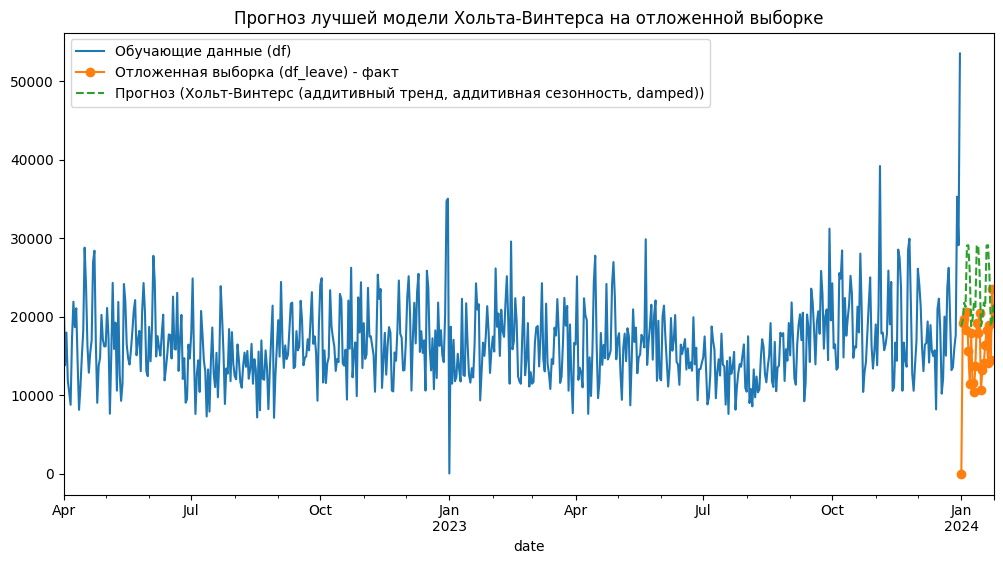

In [57]:
from statsmodels.tsa.api import ExponentialSmoothing

# Определим параметры для моделей Хольта-Винтерса
# Недельная сезонность, период = 7
seasonal_periods = 7

models_hw = {
    "Хольт (аддитивный тренд)": {"trend": "add", "seasonal": None, "seasonal_periods": None},
    "Хольт (мультипликативный тренд, damped)": {"trend": "mul", "damped_trend": True, "seasonal": None, "seasonal_periods": None},
    "Хольт-Винтерс (аддитивный тренд, аддитивная сезонность)": {"trend": "add", "seasonal": "add", "seasonal_periods": seasonal_periods},
    "Хольт-Винтерс (мультипликативный тренд, мультипликативная сезонность)": {"trend": "mul", "seasonal": "mul", "seasonal_periods": seasonal_periods},
    "Хольт-Винтерс (аддитивный тренд, мультипликативная сезонность)": {"trend": "add", "seasonal": "mul", "seasonal_periods": seasonal_periods},
    "Хольт-Винтерс (аддитивный тренд, аддитивная сезонность, damped)": {"trend": "add", "damped_trend": True, "seasonal": "add", "seasonal_periods": seasonal_periods},
    "Хольт-Винтерс (мультипликативный тренд, мультипликативная сезонность, damped)": {"trend": "mul", "damped_trend": True, "seasonal": "mul", "seasonal_periods": seasonal_periods},
}

results_cv = {}
results_leave = {}

print("--- Результаты на кросс-валидации (cv_data) ---")
for model_name, params in models_hw.items():
    try:
        def hw_model_cv(train, test):
            # use_boxcox=True может помочь стабилизировать дисперсию, особенно для мультипликативных моделей
            # initialization_method='estimated' может дать лучшие результаты, но дольше обучается
            model = ExponentialSmoothing(train,
                                         trend=params.get("trend"),
                                         damped_trend=params.get("damped_trend", False),
                                         seasonal=params.get("seasonal"),
                                         seasonal_periods=params.get("seasonal_periods"),
                                         initialization_method='heuristic', # или 'estimated'
                                         use_boxcox=False # или True, или 0.0 для логарифмирования
                                        )
            fit = model.fit(optimized=True) # optimized=True для подбора параметров
            return fit.forecast(len(test))

        MAEs_hw, mean_mae_hw, std_mae_hw = test_cv(hw_model_cv, cv_data)
        results_cv[model_name] = {"MAE_mean": mean_mae_hw, "MAE_std": std_mae_hw}
        print(f"Модель: {model_name}")
        print(f"  Среднее MAE на CV: {mean_mae_hw:.2f} ± {std_mae_hw:.2f}\n")

    except Exception as e:
        print(f"Ошибка при обучении модели {model_name} на CV: {e}\n")
        results_cv[model_name] = {"MAE_mean": float('inf'), "MAE_std": float('inf')}


print("\n--- Результаты на отложенной выборке (df_leave) ---")
# Обучаем на всем df и прогнозируем df_leave
for model_name, params in models_hw.items():
    try:
        model_final_hw = ExponentialSmoothing(df,
                                            trend=params.get("trend"),
                                            damped_trend=params.get("damped_trend", False),
                                            seasonal=params.get("seasonal"),
                                            seasonal_periods=params.get("seasonal_periods"),
                                            initialization_method='heuristic',
                                            use_boxcox=False
                                           )
        fit_final_hw = model_final_hw.fit(optimized=True)
        predictions_hw_leave = fit_final_hw.forecast(len(df_leave))

        mae_hw_on_leave = mean_absolute_error(df_leave, predictions_hw_leave)
        mse_hw_on_leave = mean_squared_error(df_leave, predictions_hw_leave)
        results_leave[model_name] = {"MAE": mae_hw_on_leave, "MSE": mse_hw_on_leave, "Predictions": predictions_hw_leave}
        print(f"Модель: {model_name}")
        print(f"  MAE на df_leave: {mae_hw_on_leave:.2f}")
        print(f"  MSE на df_leave: {mse_hw_on_leave:.2f}\n")
        # print(fit_final_hw.summary()) # Можно раскомментировать для деталей модели
    except Exception as e:
        print(f"Ошибка при обучении модели {model_name} на df_leave: {e}\n")
        results_leave[model_name] = {"MAE": float('inf'), "MSE": float('inf'), "Predictions": None}

# Сравнение моделей
print("\n--- Сводка по MAE на кросс-валидации ---")
for name, res in sorted(results_cv.items(), key=lambda item: item[1]['MAE_mean']):
    print(f"{name}: {res['MAE_mean']:.2f} ± {res['MAE_std']:.2f}")

print("\n--- Сводка по MAE на отложенной выборке (df_leave) ---")
for name, res in sorted(results_leave.items(), key=lambda item: item[1]['MAE']):
    print(f"{name}: MAE = {res['MAE']:.2f}, MSE = {res['MSE']:.2f}")

# Выбор лучшей модели по MAE на CV
best_model_name_cv = min(results_cv, key=lambda k: results_cv[k]['MAE_mean'])
print(f"\nЛучшая модель по среднему MAE на кросс-валидации: {best_model_name_cv} (MAE: {results_cv[best_model_name_cv]['MAE_mean']:.2f})")

# Выбор лучшей модели по MAE на отложенной выборке
best_model_name_leave = min(results_leave, key=lambda k: results_leave[k]['MAE'])
print(f"Лучшая модель по MAE на отложенной выборке: {best_model_name_leave} (MAE: {results_leave[best_model_name_leave]['MAE']:.2f})")

# Визуализация прогноза лучшей модели на отложенной выборке
if results_leave[best_model_name_leave]["Predictions"] is not None:
    fig, ax = plt.subplots(figsize=(12, 6))
    df.plot(ax=ax, label='Обучающие данные (df)')
    df_leave.plot(ax=ax, label='Отложенная выборка (df_leave) - факт', style='o-')
    results_leave[best_model_name_leave]["Predictions"].plot(ax=ax, label=f'Прогноз ({best_model_name_leave})', style='--')
    ax.set_title(f'Прогноз лучшей модели Хольта-Винтерса на отложенной выборке')
    ax.legend()
    plt.show()



### Задание 4. Предложить модель,  превосходящую по качеству базовую модель как можно сильнее.

Метрика качества MSE. 

Единственное ограничение модели - умение объяснять ее работу.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm # для auto_arima
from sklearn.metrics import mean_squared_error # Импортируем MSE

# Проверка на стационарность
adf_test_result = adfuller(df)
print(f'ADF Statistic: {adf_test_result[0]}')
print(f'p-value: {adf_test_result[1]}')
# Если p-value > 0.05, ряд не стационарен, нужно дифференцирование (d > 0)

# Подбор параметров с помощью auto_arima (может занять время)
# Используем обучающую выборку df для подбора параметров
auto_model_fit = pm.auto_arima(df,
                               start_p=1, start_q=1,
                               test='adf',       # использовать adf тест для определения d
                               max_p=3, max_q=3, # максимальные p и q
                               m=7,              # период сезонности (неделя)
                               start_P=0, start_Q=0,
                               seasonal=True,    # включить сезонность
                               d=None,           # пусть pmdarima определит d
                               D=1,              # сезонное дифференцирование
                               trace=True,
                               error_action='ignore',
                               suppress_warnings=True,
                               stepwise=True,
                               information_criterion='aic') # или 'bic'

print(auto_model_fit.summary())
best_order = auto_model_fit.order
best_seasonal_order = auto_model_fit.seasonal_order

print(f"\nПодобранные параметры: order={best_order}, seasonal_order={best_seasonal_order}")

# Функция для модели SARIMA для использования в test_cv
def sarima_model_cv(train, test):
    try:
        model = SARIMAX(train,
                        order=best_order,
                        seasonal_order=best_seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                        initialization='approximate_diffuse') # или другой метод инициализации
        fit = model.fit(disp=False)
        return fit.forecast(len(test))
    except Exception as e:
        print(f"Ошибка в SARIMA на CV: {e}")
        # Возвращаем наивный прогноз в случае ошибки (среднее последних 7 дней)
        return pd.Series([train.iloc[-7:].mean()] * len(test), index=test.index)

# Тестирование на кросс-валидации по MAE (как в ноутбуке)
MAEs_sarima, mean_mae_sarima, std_mae_sarima = test_cv(sarima_model_cv, cv_data)
print(f'\nСреднее значение MAE для SARIMA на CV: {mean_mae_sarima:.2f} ± {std_mae_sarima:.2f}')

# Оценка MSE на кросс-валидации
MSEs_sarima_cv = []
for ex in cv_data:
    train = ex['train']
    test = ex['test']
    predict = sarima_model_cv(train, test)
    MSEs_sarima_cv.append(mean_squared_error(test, predict))

mean_mse_sarima_cv = np.mean(MSEs_sarima_cv)
std_mse_sarima_cv = np.std(MSEs_sarima_cv)
print(f'Среднее значение MSE для SARIMA на CV: {mean_mse_sarima_cv:.2f} ± {std_mse_sarima_cv:.2f}')


# Финальный прогноз на df_leave и оценка по MSE
model_final_sarima = SARIMAX(df, # Обучаем на всем df
                             order=best_order,
                             seasonal_order=best_seasonal_order,
                             enforce_stationarity=False,
                             enforce_invertibility=False,
                             initialization='approximate_diffuse')
try:
    fit_final_sarima = model_final_sarima.fit(disp=False)
    predictions_sarima_leave = fit_final_sarima.forecast(len(df_leave))

    mae_sarima_on_leave = mean_absolute_error(df_leave, predictions_sarima_leave)
    mse_sarima_on_leave = mean_squared_error(df_leave, predictions_sarima_leave)

    print(f"\nMAE SARIMA на отложенной выборке (df_leave): {mae_sarima_on_leave:.2f}")
    print(f"MSE SARIMA на отложенной выборке (df_leave): {mse_sarima_on_leave:.2f}")

    # Сравнение с базовой моделью по MSE
    # Для этого нужно рассчитать MSE базовой модели на df_leave
    base_predictions_leave = baseline_model(df, df_leave) # Используем df как train для базовой
    mse_base_on_leave = mean_squared_error(df_leave, base_predictions_leave)
    print(f"MSE базовой модели на отложенной выборке (df_leave): {mse_base_on_leave:.2f}")

    if mse_sarima_on_leave < mse_base_on_leave:
        print("\nМодель SARIMA превосходит базовую модель по MSE на отложенной выборке.")
    else:
        print("\nМодель SARIMA не превосходит базовую модель по MSE на отложенной выборке.")

    # Визуализация
    fig, ax = plt.subplots(figsize=(12, 6))
    df.plot(ax=ax, label='Обучающие данные (df)')
    df_leave.plot(ax=ax, label='Отложенная выборка (df_leave) - факт', style='o-')
    predictions_sarima_leave.plot(ax=ax, label=f'Прогноз SARIMA', style='--')
    ax.set_title(f'Прогноз SARIMA на отложенной выборке')
    ax.legend()
    plt.show()

except Exception as e:
    print(f"Ошибка при финальном обучении/прогнозировании SARIMA: {e}")
    print("Не удалось построить финальный прогноз SARIMA.")

